# Kaggle competition: Natural Language Processing with Disaster Tweets
.

This Kaggle competition is about classifying texts. It is an excellent introduction to Natural Language Processing (NLP). 
Competition Description
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster

In [1]:
#import libraries

import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_recall_curve, auc
import tensorflow as tf
from transformers import AdamW
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertForSequenceClassification

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

/kaggle/input/twitternlp/sample_submission.csv
/kaggle/input/twitternlp/train.csv
/kaggle/input/twitternlp/test.csv


# Step 1:Brief description of the problem and data 


Natural Language processing is a deep learning method which classifies texts and this is useful for analyzing massive amount of text data and pulling out classifying features. In this project the datas are posts from twitter, which can be programmatically monitored to detect an announcement of an emergency/ natural disaster. This can be important to monitor in a time of emergency so that responders can have the most information possible about the event by reading the responses from the general public in a mass way that quickly characterizes which tweets are related. 

Dimension of data:
Test Set Shape = (3263, 4)
Training Set Shape = (7613, 5)

Training and testing data has id, keyword, location,and text information

In [2]:
#import data
test = pd.read_csv('/kaggle/input/twitternlp/test.csv')
train = pd.read_csv('/kaggle/input/twitternlp/train.csv')

#visualize data

print('train head:',train.head())
print('test head:',test.head())
print('Test Set Shape = {}'.format(test.shape))
print('Training Set Shape = {}'.format(train.shape))

train head:    id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
test head:    id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwa

# Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data 
First in EDA, it is necessary to check for null values and drop them. A histogram of target distribution and text length is then output for visualization of the data.

Missing Values in Training Data:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Missing Values in Testing Data:
id             0
keyword       26
location    1105
text           0
dtype: int64


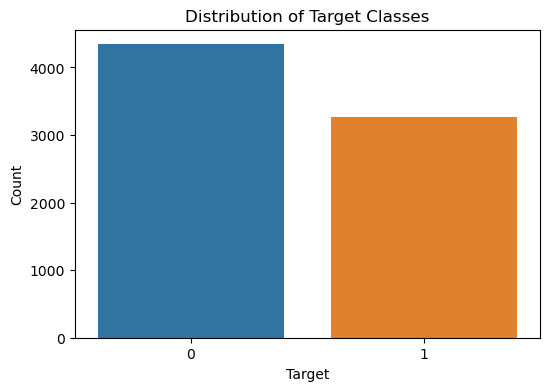

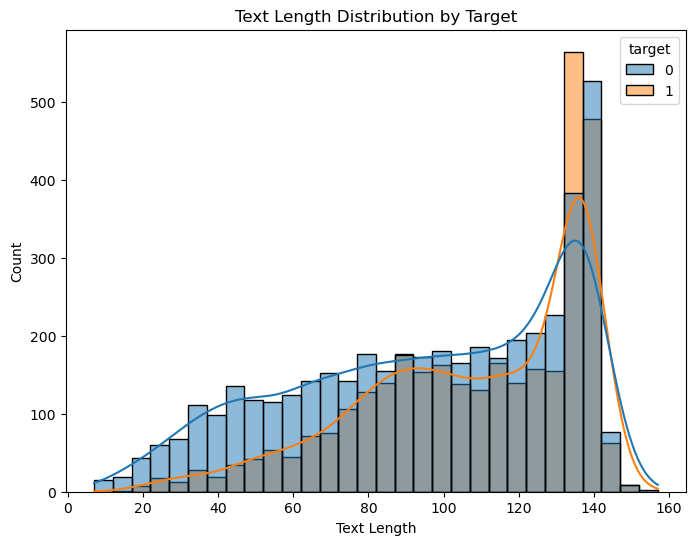

In [3]:
# Clean
# Check for missing values
print('Missing Values in Training Data:')
print(train.isnull().sum())
print('Missing Values in Testing Data:')
print(test.isnull().sum())

# Histogram: distribution target classes
plt.figure(figsize=(6, 4))
sns.countplot(data=train, x='target')
plt.title('Distribution of Target Classes')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

# Visualize text length: train
train['text_length'] = train['text'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(data=train, x='text_length', hue='target', bins=30, kde=True)
plt.title('Text Length Distribution by Target')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()




The mode text length is ~130-140

In [5]:
# Remove unnecessary columns
train = train.drop(columns=['id', 'keyword', 'location'])

# Remove any rows with missing values

train = train.dropna()


# Summary Statistics
print('Summary Statistics of Text Length:')
print(train['text_length'].describe())

Summary Statistics of Text Length:
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text_length, dtype: float64


https://www.kaggle.com/code/billycemerson/nlp-text-classification-svm for preprocessing methods

# Step 3: Model Architecture


I chose a BERT word embedding for this project. BERT is a good option for word embedding, as it can distinquish differences in semantic meanings. In other words, it accounts for context. It stands for Bidirectional Encoder Representations from Transformers, is a language model which is able to achieve question-answering and language understanding. It takes numbers as an input so text must be tokanized. The model is pre-trained on a large amount of data and open source.

This is a bidirectional model, which means the transformer encoder reads the entire sequence of words all at once instead of sequentially (left-to-right or right-to-left) It is considered birectional, but in reality it is non-directional. It then can learn the context of the word based on surrounding words. This is important for disaster characterizing tweets in a age where "This outfit is fire" has a different meaning than "The entire neighborhood is on fire"

BERT uses two training strategies. The first is MLM (masked LM) where 15% of the words in the sequence are replaced with a mask token, then the model attempts to predict the masked word based on context. The architecture of the MLM looks as such: 
1) Add a classification layer on top of the encoder output.
2) Multiply the output vectors by the embedding matrix, transforming them into the vocabulary dimension. 
3)Calculate the probability of each word in the vocabulary with softmax.

Then it uses Next sentance prediction (NSP). During training 50% of the sentances are paired with the original sentance and the rest are paired with a random second sentance from the corpus. The model is then trained to distinquish which are disconnected from the context. The architecture is as follows: 
1) A CLS token is inserted at the beginning of the first sentence and a SEP token is inserted at the end of each sentence. 
2) A sentence embedding indicating Sentence A or Sentence B is added to each token. Sentence embeddings are similar in concept to token embeddings with a vocabulary of 2.
3)A positional embedding is added to each token to indicate its position in the sequence. The concept and implementation of positional embedding are presented in the Transformer paper. 

The next sentance prediction may not always be useful in a tweet context, where characters are limited and short form, but regardless the BERT architecture is robust and was selected as the best for this characterization.

https://towardsdatascience.com/bert-why-its-been-revolutionizing-nlp-5d1bcae76a13

https://arxiv.org/pdf/1810.04805.pdf

https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270



In [6]:
#NLP technique language process architecture. BERT
#build and train neural network model

# Data Splitting
train_df, val_df = train_test_split(train, test_size=0.1, stratify=train['target'])

First, the data must be tokanized before feeding into BERT which converts to numerical and creates attention masks. https://arxiv.org/pdf/1810.04805.pdf

In [7]:
# BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

max_length = 160

# Tokenize the text
train_texts = list(train_df['text'])
train_inputs = tokenizer(train_texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")


val_texts = list(val_df['text'])
val_inputs = tokenizer(val_texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")


In [8]:
# Create Dataloader
batch_size = 16
train_labels = train_df['target'].values

val_labels = val_df['target'].values

train_dataset = TensorDataset(train_inputs.input_ids, train_inputs.attention_mask, torch.tensor(train_labels))
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)


val_dataset = TensorDataset(val_inputs.input_ids, val_inputs.attention_mask, torch.tensor(val_labels))
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)


train_dataset


In [9]:
# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=2)

# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation F1 Score: 0.8018720748829953
Validation Accuracy: 0.8333333333333334
Validation F1 Score: 0.7882534775888717
Validation Accuracy: 0.8202099737532809
Validation F1 Score: 0.7884322678843226
Validation Accuracy: 0.8175853018372703
Early stopping triggered.


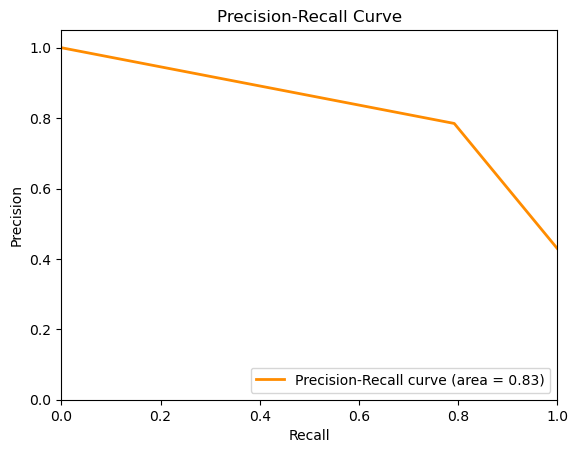

In [11]:
import torch
from sklearn.metrics import f1_score, accuracy_score
from transformers import AdamW
from sklearn.model_selection import ParameterGrid


def train_epoch(model, train_dataloader, optimizer, accum_steps):
    model.train()
    for step, batch in enumerate(train_dataloader):
        input_ids, attention_mask, train_labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        train_labels = train_labels.to(device)

        optimizer.zero_grad() if step % accum_steps == 0 else None
        output = model(input_ids, attention_mask=attention_mask, labels=train_labels)
        loss = output.loss
        loss.backward()

        if (step + 1) % accum_steps == 0:
            optimizer.step()

def validate(model, val_dataloader):
    model.eval()
    val_preds = []
    val_true = []
    for batch in val_dataloader:
        input_ids, attention_mask, val_labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        with torch.no_grad():
            output = model(input_ids, attention_mask=attention_mask)
            val_preds.extend(torch.argmax(output.logits, axis=1).tolist())
            val_true.extend(val_labels.tolist())

    val_f1 = f1_score(val_true, val_preds)
    val_acc = accuracy_score(val_true, val_preds)
    return val_f1, val_acc, val_true, val_preds

def main():
  
    optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
    early_stopping_rounds = 2
    accum_steps = 4

    best_f1 = 0
    stopping_rounds = 0

    for epoch in range(accum_steps):
        train_epoch(model, train_dataloader, optimizer, accum_steps)
        val_f1, val_acc, val_true, val_preds = validate(model, val_dataloader)
        
        print(f"Validation F1 Score: {val_f1}")
        print(f"Validation Accuracy: {val_acc}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            stopping_rounds = 0
        else:
            stopping_rounds += 1
            if stopping_rounds >= early_stopping_rounds:
                print("Early stopping triggered.")
                break
   
    precision, recall, _ = precision_recall_curve(val_true, val_preds)
    pr_auc = auc(recall, precision)

    # Plot Precision-Recall Curve
    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    plt.show()
    
if __name__ == "__main__":
    main()

Tuning hyper-parameter:
Batch size: 32
Learning rate : 2e-5 
Number of Training Epochs (accum_steps):4
Bert-base-unencased

Validation F1 Score: 0.7941653160453809
Validation Accuracy: 0.8333333333333334
Validation F1 Score: 0.8012718600953895
Validation Accuracy: 0.8359580052493438
Validation F1 Score: 0.7861635220125787
Validation Accuracy: 0.821522309711286
Validation F1 Score: 0.7877862595419847
Validation Accuracy: 0.8175853018372703
Precision recall area: 0.83

Learning rate : 1e-5 (went with this learning curve)

Validation F1 Score: 0.7906976744186047
Validation Accuracy: 0.8228346456692913
Validation F1 Score: 0.7981366459627329
Validation Accuracy: 0.8293963254593176
Validation F1 Score: 0.7849293563579278
Validation Accuracy: 0.8202099737532809
Validation F1 Score: 0.7841409691629957
Validation Accuracy: 0.8070866141732284
Precision recall area: 0.82

Batch size: 16, LR: 1e-5

Validation F1 Score: 0.7899408284023669
Validation Accuracy: 0.8136482939632546
Validation F1 Score: 0.8006182380216383
Validation Accuracy: 0.8307086614173228
Validation F1 Score: 0.7926267281105991
Validation Accuracy: 0.8228346456692913
Validation F1 Score: 0.7935483870967741
Validation Accuracy: 0.8320209973753281
Precision recall area: 0.85

Batch size: 64, LR: 1e-5
Validation F1 Score: 0.7327044025157233
Validation Accuracy: 0.7769028871391076
Validation F1 Score: 0.7766116941529235
Validation Accuracy: 0.8044619422572179
Validation F1 Score: 0.8043818466353677
Validation Accuracy: 0.8359580052493438
Validation F1 Score: 0.789308176100629
Validation Accuracy: 0.8241469816272966
Precision recall area: 0.84

Best Batch 16-LR: 1e-5

Number of Training Epochs (accum_steps): 6

Validation F1 Score: 0.7545076282940361
Validation Accuracy: 0.7677165354330708
Validation F1 Score: 0.799373040752351
Validation Accuracy: 0.8320209973753281
Validation F1 Score: 0.7926829268292682
Validation Accuracy: 0.821522309711286
Validation F1 Score: 0.7908396946564885
Validation Accuracy: 0.8202099737532809
Precision recall area: 0.84

Number of Training Epochs (accum_steps): 3
Validation F1 Score: 0.7921440261865794
Validation Accuracy: 0.8333333333333334
Validation F1 Score: 0.7833065810593902
Validation Accuracy: 0.8228346456692913
Validation F1 Score: 0.7789799072642968
Validation Accuracy: 0.8123359580052494
Precision recall area: 0.83

Best: Batch size: 16, LR: 1e-5, accum_steps=4
Bert-large-unencased, better large-unencased

Validation F1 Score: 0.7765042979942692
Validation Accuracy: 0.7952755905511811
Validation F1 Score: 0.7943037974683544
Validation Accuracy: 0.8293963254593176
Validation F1 Score: 0.801292407108239
Validation Accuracy: 0.8385826771653543
Validation F1 Score: 0.7920133111480865
Validation Accuracy: 0.8359580052493438
Precision recall area: 0.86

# Step 4: Results and Analysis 

Hyperparameter tuning: 

The following hyperparameters were tuned in order to find the best model:

Learning rate: The learning rate controls the step size that the optimizer takes during gradient descent. It affects the speed at which the model learns and can impact convergence. 
The best learning rate was:1e-5

Batch Size (batch_size): The batch size determines how many examples are processed in each forward and backward pass. 
The best batch size:16

Number of Training Epochs (accum_steps): 
The best number of trainings was found to be:4

Early Stopping Rounds: Early stopping was incorporated to  prevent overfitting by monitoring the validation performance and stopping training when it no longer improves.

BERT Model Variant ('bert-base-uncased'): The 'bert-base-uncased' model was used initially but the accuracy and validation performance improved when 'bert-large-uncased' was used.

This was analyzed by printing validation and accuracy scores in the write up from different variations. And each iteration of this was shown above with the validation and accuracy for different hyperparameters. 

After this a sample submission is evaluated and confusion matrix plotted to access classification.




In [12]:
evaluate_text = list(test['text'])
evaluate_inputs = tokenizer(evaluate_text, padding="max_length", truncation=True, max_length=64, return_tensors="pt")
evaluate_inputs = {key: val.to(device) for key, val in evaluate_inputs.items()}  # Send the inputs to the same device as model

predictions = []
# model.eval()

# Adjusting the DataLoader to use evaluate_inputs instead of train_inputs
for input_ids, attention_mask in DataLoader(TensorDataset(evaluate_inputs['input_ids'], evaluate_inputs['attention_mask']), batch_size=batch_size):
    with torch.no_grad():
        # Send the input tensors to the same device as model
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        output = model(input_ids, attention_mask=attention_mask)
        predictions.extend(torch.argmax(output.logits, axis = 1).tolist())

In [14]:

test["target"] = predictions
submission = test[["id", "target"]]

sample_submission = pd.read_csv("/kaggle/input/twitternlp/sample_submission.csv")
sample_submission.head()


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [15]:
# Evaluate the model on the validation set
model.eval()
all_val_preds = []

for batch in val_dataloader:
    batch = [item.to(device) for item in batch]  # Move data to device
    input_ids, attention_mask, val_batch_labels = batch
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        val_preds = torch.argmax(outputs.logits, dim=1)
        all_val_preds.extend(val_preds.cpu().numpy())

print(len(val_labels))  # Length of val_labels
print(len(all_val_preds))  # Length of all_val_preds

762
762


In [16]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(val_labels, all_val_preds)

# Print or visualize the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[364  71]
 [ 68 259]]


The confusion matrix shows a relatively high success in classification

# Step 5: Conclusion
 
In summary, the best model had a batch size of 16, a learning rate of 1e-5, 4 epochs, and used bert-large-unencased. While this model ran slightly slower, it had the best F1 score, validation accuracy and precision recall. 

Validation F1 Score: 0.7765042979942692
Validation Accuracy: 0.7952755905511811
Validation F1 Score: 0.7943037974683544
Validation Accuracy: 0.8293963254593176
Validation F1 Score: 0.801292407108239
Validation Accuracy: 0.8385826771653543
Validation F1 Score: 0.7920133111480865
Validation Accuracy: 0.8359580052493438
Precision recall area: 0.86

BERT word embedding was a good option for this project, as it is able to distinquish differences in word context and semantics. In other words, it accounts for context. In the future it would be nice to try some other word embedding models to compare, as well as have some better visualizations of the tweets, converting them back to text from tokens to print some of the classified tweets and affirm that they are in fact catagorizing disaster. With a performance accuracy at a high of 0.838, and F1 score 0.80, this trained and classified disaster text relatively well.


References:
https://towardsdatascience.com/bert-why-its-been-revolutionizing-nlp-5d1bcae76a13

https://arxiv.org/pdf/1810.04805.pdf

https://www.kaggle.com/code/sarashahin/bertnaturallanguageprocessing-with-disastertweets
https://www.kaggle.com/code/unstoppablesk/tweetsdisaster

https://www.kaggle.com/code/billycemerson/nlp-text-classification-svm